<a href="https://colab.research.google.com/github/Jgmedina95/molbloom-paper/blob/main/molbloom_time_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install molbloom


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 4.4 MB/s eta 0:00:00


In [2]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 2.6 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
import numpy as np
import math
import os
import urllib
from dataclasses import dataclass
import json
import sys
from molbloom import CustomFilter, canon
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, AllChem, MACCSkeys, rdMolDescriptors
import time
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
import json
#np.random.seed(0)
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   
           })

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with open("/content/drive/MyDrive/COCONUT_DB.smi", "r") as f:
    smi_list = f.readlines()
#smi_list

In [6]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning') #this is for cleaner presentation. A lot of messages of the type: [13:19:48] Explicit valence for atom # 3 B, 4, is greater than permitted

In [11]:
#python implementation of bloom filter with fps

def create_empty_bloom_filter(size):
    return np.zeros(size)

def hashed_indexes(h1,h2,size):
  indexes = []
  for i in range(max(8, min(64, int(size / int(406919/2) * math.log(2))))):
     indexes.append(((h1) + i*(h2))%size)
  return indexes

def add_molecules(fp1,fp2,bf,size):
  h1 = int(DataStructs.BitVectToText(fp1),base=2)
  h2 = int(DataStructs.BitVectToText(fp2),base=2)
  for index in hashed_indexes(h1,h2,size):
    bf[index]=1
  return bf
  
def check_molecule(fp1, fp2, bf, size):
    h1 = int(DataStructs.BitVectToText(fp1), base=2)
    h2 = int(DataStructs.BitVectToText(fp2), base=2)
    for index in hashed_indexes(h1, h2, size):
        if bf[index] == 0:
            return False
    return True

In [ ]:
mols = []
can_smiles = []
for i,smi in enumerate(smi_list):
  mol = Chem.MolFromSmiles(smi.split(" ")[0])
  if mol:
    mols.append(mol)
    can_smiles.append(Chem.MolToSmiles(mol,True))

In [8]:
#time experiments
fpr_smi = []
avg_times = []
bloom_size = [10,100,1000,10000,50000,100000,150000,200000,250000,300000,350000,400000,450000,500000,550000,600000,650000,700000,750000,800000,850000,900000,950000,1000000,2000000,3000000,4000000,5000000,10_000_000,100_000_000]
split = int(len(mols)/2)
for size in bloom_size:
  bloom_smi = CustomFilter(size,200000,"myfilter")
  is_not_smiles = []
  timings = []
  for i,smi in enumerate(smi_list):
    if i <split:
        bloom_smi.add(smi.split(" ")[0])
    if i > split:       
        start_time = time.time()
    
    # check if the molecule is in the filter
        if bloom_smi.__contains__(smi.split(" ")[0]):
            pass
    
    # stop the timer and record the timing
        timing = time.time() - start_time
        timings.append(timing)
        is_not_smiles.append(bloom_smi.__contains__(smi.split(" ")[0]))
  avg_time = sum(timings) / len(timings)
  avg_times.append(avg_time)
  #print(f"Average time to check a molecule: {avg_time:.8f} seconds")
  fpr_smi.append(100-(len(is_not_smiles)-sum(is_not_smiles))*100/len(is_not_smiles))
  #print(size,len(is_not_smiles))
  #print(f'false positive rate smiles: {100-(len(is_not_smiles)-sum(is_not_smiles))*100/len(is_not_smiles)}')
avg_check = sum(avg_times)/len(avg_times)

In [9]:
total_time_mol_from_smiles = 0.0
total_time_mol_to_smiles = 0.0
counter = 0
for i, smi in enumerate(smi_list):
    # Time for MolFromSmiles
    start_time = time.time()
    mol = Chem.MolFromSmiles(smi.split(" ")[0])
    if mol:
        mols.append(mol)
    end_time = time.time()
    total_time_mol_from_smiles += end_time - start_time
    
    # Time for MolToSmiles
    if mol:
        counter +=1
        start_time = time.time()
        can_smi = Chem.MolToSmiles(mol, True)
        if can_smi:
            can_smiles.append(can_smi)
        else:
            print(f'error with {smi}')
        end_time = time.time()
        total_time_mol_to_smiles += end_time - start_time

avg_time_mol_from_smiles = total_time_mol_from_smiles / len(smi_list)
avg_time_mol_to_smiles = total_time_mol_to_smiles / counter
print(f"Average time for MolFromSmiles: {avg_time_mol_from_smiles:.8f} seconds")
print(f"Average time for MolToSmiles: {avg_time_mol_to_smiles:.8f} seconds")

[16:09:10] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:09:10] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:09:10] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:09:10] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:09:10] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:09:11] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:09:11] Explicit valence for atom # 37 N, 4, is greater than permitted
[16:09:11] Explicit valence for atom # 23 N, 4, is greater than permitted
[16:09:11] Explicit valence for atom # 8 N, 4, is greater than permitted


Average time for MolFromSmiles: 0.00024372 seconds
Average time for MolToSmiles: 0.00015386 seconds


In [12]:
##Time stude for fingerprints 
# Define the size of the Bloom filter
bf_size = 1000000

# Initialize the Bloom filter with all zeros
bf = [0] * bf_size

# Initialize variables to keep track of the total time for each step
mol_total_time = 0
rdk_total_time = 0
maccs_total_time = 0
check_total_time = 0
counter = 0
# Loop through the list of SMILES strings
for i,smile in enumerate(smi_list):
    # Start timing the RDKit fingerprint generation
    smi= smile.split(" ")[0]
    if i >20000:
        break
    mol_start_time = time.time()
    # Convert the SMILES string to an RDKit molecule object
    mol = Chem.MolFromSmiles(smi)
    mol_end_time = time.time()
    mol_time = mol_end_time - mol_start_time
    mol_total_time += mol_time
    
    if mol:
        counter +=1
        rdk_start_time = time.time()
        # Generate the RDKit fingerprint
        rdk_fp = Chem.RDKFingerprint(mol)
    
        # Stop timing the RDKit fingerprint generation and add the elapsed time to the running total
        rdk_end_time = time.time()
        rdk_time = rdk_end_time - rdk_start_time
        rdk_total_time += rdk_time

        # Start timing the MACCS fingerprint generation
        maccs_start_time = time.time()
    
        # Generate the MACCS fingerprint
        maacs_fp = MACCSkeys.GenMACCSKeys(mol)
    
        # Stop timing the MACCS fingerprint generation and add the elapsed time to the running total
        maccs_end_time = time.time()
        maccs_time = maccs_end_time - maccs_start_time
        maccs_total_time += maccs_time

        # Start timing the Bloom filter check
        check_start_time = time.time()
    
        # Check if the molecule is already present in the Bloom filter
        is_present = check_molecule(rdk_fp, maacs_fp, bf, bf_size)
    
        # Stop timing the Bloom filter check and add the elapsed time to the running total
        check_end_time = time.time()
        check_time = check_end_time - check_start_time
        check_total_time += check_time
    
    # Print a message indicating whether the molecule is in the Bloom filter or not
    #if is_present:
    #    print("Molecule with SMILES", smiles, "is already in the Bloom filter")
    #else:
    #    print("Molecule with SMILES", smiles, "is not in the Bloom filter")

# Calculate the average time for each step
num_molecules = 20000
mol_avg_time = mol_total_time /num_molecules
rdk_avg_time = rdk_total_time / counter
maccs_avg_time = maccs_total_time / counter
check_avg_time = check_total_time / counter
total_avg_fp_time = mol_avg_time+rdk_avg_time+maccs_avg_time + check_avg_time 
# Print out the average times
print("Average mol object generation time:", mol_avg_time)
print("Average RDKit fingerprint generation time:", rdk_avg_time)
print("Average MACCS fingerprint generation time:", maccs_avg_time)
print("Average Bloom filter check time:", check_avg_time)
print("total average:", total_avg_fp_time)

Average mol object generation time: 0.00027642457485198973
Average RDKit fingerprint generation time: 0.0012372687524635885
Average MACCS fingerprint generation time: 0.0013966258640617764
Average Bloom filter check time: 6.72558450106864e-05
total average: 0.002977575036388041


In [13]:
#time test using coconut API with 500 retrievals
total_time = 0.0
for i,smi in enumerate(smi_list):
    if i>500:
        break
    try:
#        if i%100 == 0:
#            print(i)
        smile = smi.split(" ")[0]
        #print(smile)
        start_time = time.time()
        page = f"https://coconut.naturalproducts.net/api/search/exact-structure?type=smiles&smiles={smile}"
        #print(page)
        response = urlopen(page)
        body = response.read()
        todo_item = json.loads(body)
        todo_item['count']
        end_time = time.time()
        total_time += end_time - start_time
    except HTTPError:
         print("Something bad happened")
    else:
        pass
avg_api_time = total_time/ 500

0
Something bad happened
Something bad happened
Something bad happened
100
Something bad happened
200
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
300
400
500


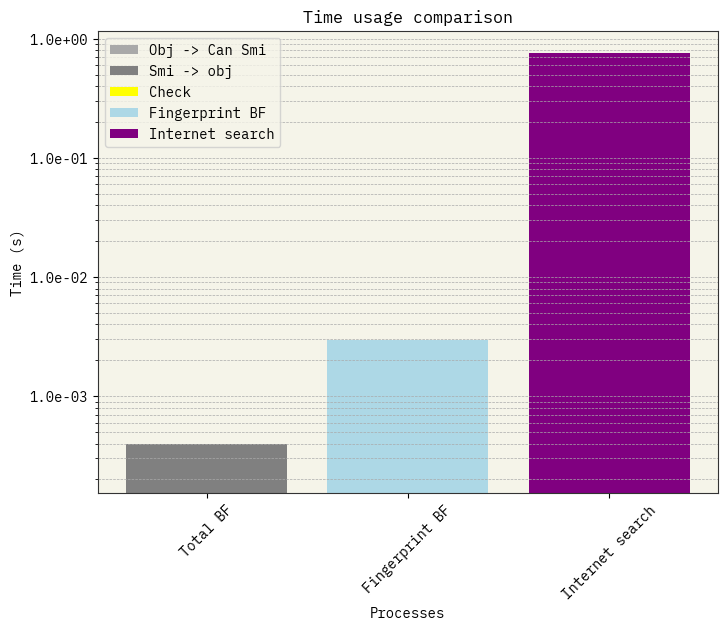

In [15]:
# Sample data
x = ['Total BF', 'Fingerprint BF', 'Internet search']
y1 = [avg_time_mol_to_smiles, 0, 0]
y2 = [avg_time_mol_from_smiles, 0, 0]
y3 = [avg_check, 0, 0]
y4 = [0, total_avg_fp_time, 0]
y5 = [0, 0, avg_api_time]

plt.figure(figsize=(8, 6))

# Create the first stacked bar with different colors
bottom_y2 = [sum(y) for y in zip(y1)]
bottom_y3 = [sum(y) for y in zip(y1, y2)]

plt.bar(x[0], y1[0], color='darkgray', label='Obj -> Can Smi')
plt.bar(x[0], y2[0], color='gray', bottom=bottom_y2[0], label='Smi -> obj')
plt.bar(x[0], y3[0], color='yellow', bottom=bottom_y3[0], label='Check')

# Add the other bars normally
plt.bar(x[1:], y4[1:], color='lightblue', label='Fingerprint BF')
plt.bar(x[1:], y5[1:], color='purple', label='Internet search')

# Set plot title and axis labels
plt.title('Time usage comparison')
plt.xlabel('Processes')
plt.ylabel('Time (s)')
plt.yscale('log')
#plt.yticks(ticks=plt.yticks()[0], labels=[f"{tick:.6f}" for tick in plt.yticks()[0]])
formatter = FuncFormatter(lambda y, _: f"{y:.1e}")
plt.gca().yaxis.set_major_formatter(formatter)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add gridlines
plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)

# Add a horizontal line at y=0
plt.axhline(0, color='black', linewidth=0.5)

# Add legend
plt.legend(loc='upper left')

# Show plot
plt.show()


In [14]:
print(avg_time_mol_to_smiles)
print(avg_time_mol_from_smiles)
print(avg_check)
print(total_avg_fp_time)
print(avg_api_time)

0.00015385545245535665
0.00024371773189666723
8.832443459037905e-07
0.002977575036388041
0.7583516907691955
